In [1]:
# импортируем библиотеки pandas, numpy, missingno,
# SimpleImputer, функции  train_test_split() 
# и display()
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from IPython.display import display

# включаем режим 'retina', если у вас экран Retina
%config InlineBackend.figure_format = 'retina'

In [2]:
# записываем CSV-файл в объект DataFrame
data = pd.read_csv('Data/Verizon_missing.csv', sep=';')
# выведем первые 3 наблюдения
data.head()

,longdist,internat,local,age,income,billtype,pay,churn
0,16.0,0.0,5.0,46.0,34805.5,Бюджетный,CC,0
1,0.0,0.0,5.0,59.0,60111.8,NaN,NaN,1
2,13.0,0.0,NaN,NaN,13126.9,Бюджетный,Auto,0
3,NaN,0.0,10.0,36.0,NaN,NaN,CH,0
4,NaN,NaN,10.0,38.0,17499.2,Бесплатный,Auto,0


In [3]:
# смотрим количество пропусков по каждой переменной
data.isnull().sum()

longdist     8
internat    34
local       14
age          8
income      29
billtype    24
pay         15
churn        0
dtype: int64

In [4]:
# общее количество пропусков
data.isnull().sum().sum()

132

In [5]:
# создаем обучающий массив признаков, тестовый массив признаков,
# обучающий массив меток, тестовый массив меток
train, test, y_train, y_test = train_test_split(
    data.drop('churn', axis=1), 
    data['churn'], 
    test_size=.3, 
    stratify=data['churn'], 
    random_state=100)

In [6]:
# смотрим частоты категорий признака pay
print("TRAIN:")
print(train['pay'].value_counts(dropna=False))
print("")
print("TEST:")
print(test['pay'].value_counts(dropna=False))

TRAIN:
CC      42
CH      25
Auto    19
NaN     13
CD       1
Name: pay, dtype: int64

TEST:
CC      22
CH      14
Auto     5
NaN      2
CD       1
Name: pay, dtype: int64


In [7]:
# выполняем импутацию модой
train['pay'].fillna(train['pay'].value_counts().index[0],
                    inplace=True)
test['pay'].fillna(train['pay'].value_counts().index[0], 
                   inplace=True)

In [8]:
# смотрим частоты категорий признака pay
print("TRAIN:")
print(train['pay'].value_counts(dropna=False))
print("")
print("TEST:")
print(test['pay'].value_counts(dropna=False))

TRAIN:
CC      55
CH      25
Auto    19
CD       1
Name: pay, dtype: int64

TEST:
CC      24
CH      14
Auto     5
CD       1
Name: pay, dtype: int64


In [9]:
# печатаем среднее признака income
print(f"среднее значение income: {train['income'].mean()}")
# печатаем значение признака income
# в строке с индексом 4
print(train['income'].iloc[4])
print(test['income'].iloc[4])
# выполняем импутацию средним
train['income'].fillna(train['income'].mean(),
                       inplace=True)
test['income'].fillna(train['income'].mean(), 
                      inplace=True)
# печатаем значение признака income
# в строке с индексом 4
print(train['income'].iloc[4])
print(test['income'].iloc[4])

среднее значение income: 46635.54195121954
nan
nan
46635.54195121954
46635.54195121953


In [10]:
# взглянем на первые 5 наблюдений каждой выборки
display(train.head())
display(test.head())

,longdist,internat,local,age,income,billtype,pay
18,19.0,NaN,11.0,88.0,66906.600000,Бесплатный,CH
19,19.0,NaN,96.0,79.0,37571.100000,Бесплатный,CC
66,0.0,0.0,1.0,94.0,13946.800000,Бюджетный,CC
65,9.0,6.0,12.0,93.0,46771.200000,Бюджетный,CC
74,26.0,0.0,NaN,32.0,46635.541951,Бюджетный,Auto


,longdist,internat,local,age,income,billtype,pay
44,3.0,0.0,9.0,45.0,70239.800000,Бесплатный,CC
59,21.0,NaN,NaN,33.0,60170.100000,NaN,CH
51,29.0,NaN,110.0,29.0,18861.600000,Бюджетный,CC
35,12.0,0.0,55.0,62.0,13965.400000,Бесплатный,CH
55,25.0,0.0,77.0,95.0,46635.541951,NaN,Auto


In [11]:
# пишем класс, выполняющий импутацию 
# групповыми статистиками
class GroupImputer():
    """
    Автор: Eryk Lewinson
    https://github.com/erykml
    
    Класс, выполняющий импутацию групповыми статистиками.
    
    Параметры
    ----------    
    group_cols: list
        Список группирующих столбцов.
    agg_col: str
        Агрегируемый столбец.
    agg_func: str
        Агрегирующая функция.
    """
    def __init__(self, group_cols, agg_col, agg_func='mean', return_df=True):
        
        if agg_func not in ['mean', 'median', 'min', 'max']:
            raise ValueError(f"Неизвестная агрегирующая функция {agg_func}")
            
        if type(group_cols) != list:
            raise ValueError("Задайте список группирующих столбцов")
        
        if type(agg_func) != str:
            raise ValueError("Агрегирующая функция должна" + 
                             "иметь строковое значение")
            
        self.group_cols = group_cols
        self.agg_col = agg_col
        self.agg_func = agg_func
        self.return_df = return_df
    
    def fit(self, X, y=None):
        
        # проверка наличия пропусков в группирующих столбцах
        if pd.isnull(X[self.group_cols]).any(axis=None) == True:
             raise ValueError(f"Есть пропуски в группирующих столбцах")
        
        # получение датафрейма с групповыми статистиками
        self.impute_map_ = X.groupby(self.group_cols)[self.agg_col].agg(
            self.agg_func).reset_index(drop=False)
        
        return self 
    
    def transform(self, X, y=None):
        
        X = X.copy()
        
        # заполнение пропусков с помощью датафрейма 
        # с групповыми статистиками
        for index, row in self.impute_map_.iterrows():
            ind = (X[self.group_cols] == row[self.group_cols]).all(axis=1)
            X.loc[ind, self.agg_col] = X.loc[ind, self.agg_col].fillna(
                row[self.agg_col])
            
        if not self.return_df:
            X = X.values
        
        return X

In [12]:
# выполняем импутацию пропусков признака local групповыми 
# средними - средними значениями признака local,
# вычисленным по категориям признака pay
imp = GroupImputer(['pay'], agg_col='local', agg_func='mean')
imp.fit(train)
train = imp.transform(train)
test = imp.transform(test)

In [13]:
# взглянем на первые 5 наблюдений каждой выборки
display(train.head())
display(test.head())

,longdist,internat,local,age,income,billtype,pay
18,19.0,NaN,11.000000,88.0,66906.600000,Бесплатный,CH
19,19.0,NaN,96.000000,79.0,37571.100000,Бесплатный,CC
66,0.0,0.0,1.000000,94.0,13946.800000,Бюджетный,CC
65,9.0,6.0,12.000000,93.0,46771.200000,Бюджетный,CC
74,26.0,0.0,31.666667,32.0,46635.541951,Бюджетный,Auto


,longdist,internat,local,age,income,billtype,pay
44,3.0,0.0,9.000000,45.0,70239.800000,Бесплатный,CC
59,21.0,NaN,65.130435,33.0,60170.100000,NaN,CH
51,29.0,NaN,110.000000,29.0,18861.600000,Бюджетный,CC
35,12.0,0.0,55.000000,62.0,13965.400000,Бесплатный,CH
55,25.0,0.0,77.000000,95.0,46635.541951,NaN,Auto


In [14]:
# смотрим частоты категорий признака billtype
train['billtype'].value_counts(dropna=False)

Бюджетный     50
Бесплатный    37
NaN           13
Name: billtype, dtype: int64

In [15]:
# выполняем импутацию с помощью CHAID
from CHAID import Tree
# сконкатенируем обучающий массив признаков и массив меток
train_data = pd.concat([train, y_train], axis=1)
# задаем название предиктора
independent_variable = 'billtype'
# задаем название зависимой переменной
dep_variable = 'churn'
# создаем словарь, где ключом будет название 
# предиктора, а значением - тип переменной
dct = {independent_variable: 'nominal'}
# строим дерево CHAID и выводим его
tree = Tree.from_pandas_df(data, dct, dep_variable, max_depth=1)
tree.print_tree()

([], {0: 78.0, 1: 66.0}, (billtype, p=0.01635323632289041, score=5.764489380588449, groups=[['<missing>', 'Бесплатный'], ['Бюджетный']]), dof=1))
|-- (['<missing>', 'Бесплатный'], {0: 34.0, 1: 42.0}, <Invalid Chaid Split> - the max depth has been reached)
+-- (['Бюджетный'], {0: 44.0, 1: 24.0}, <Invalid Chaid Split> - the max depth has been reached)



In [16]:
# увеличиваем количество выводимых столбцов
pd.set_option('display.max_columns', 60)
# загружаем набор данных
data = pd.read_csv('Data/Credit_OTP_short.csv', sep=';')
# выводим первые 5 наблюдений
data.head()

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,CREDIT,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME
0,59910150,0,49,1,0,1,2,1,Среднее специальное,Состою в браке,Торговля,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,5000,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,8000.00,8650.0,220,18.0
1,59910230,0,32,1,0,1,3,3,Среднее,Состою в браке,Торговля,Рабочий,Индивидуальный предприниматель,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,21650.00,4000.0,137,97.0
2,59910525,0,52,1,0,1,4,0,Неполное среднее,Состою в браке,Информационные технологии,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,9000,Иркутская область,Иркутская область,Иркутская область,Иркутская область,ВОСТОЧНО-СИБИРСКИЙ,33126.00,4000.0,251,84.0
3,59910803,0,39,1,0,1,1,1,Высшее,Состою в браке,Образование,Руководитель среднего звена,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,25000,Ростовская область,Ростовская область,Ростовская область,Ростовская область,ЮЖНЫЙ,8491.82,5000.0,36,168.0
4,59911781,0,30,1,0,0,0,0,Среднее,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 10000 до 20000 руб.,12000,Кабардино-Балкария,Кабардино-Балкария,Кабардино-Балкария,Ставропольский край,ЮЖНЫЙ,21990.00,4000.0,83,101.0


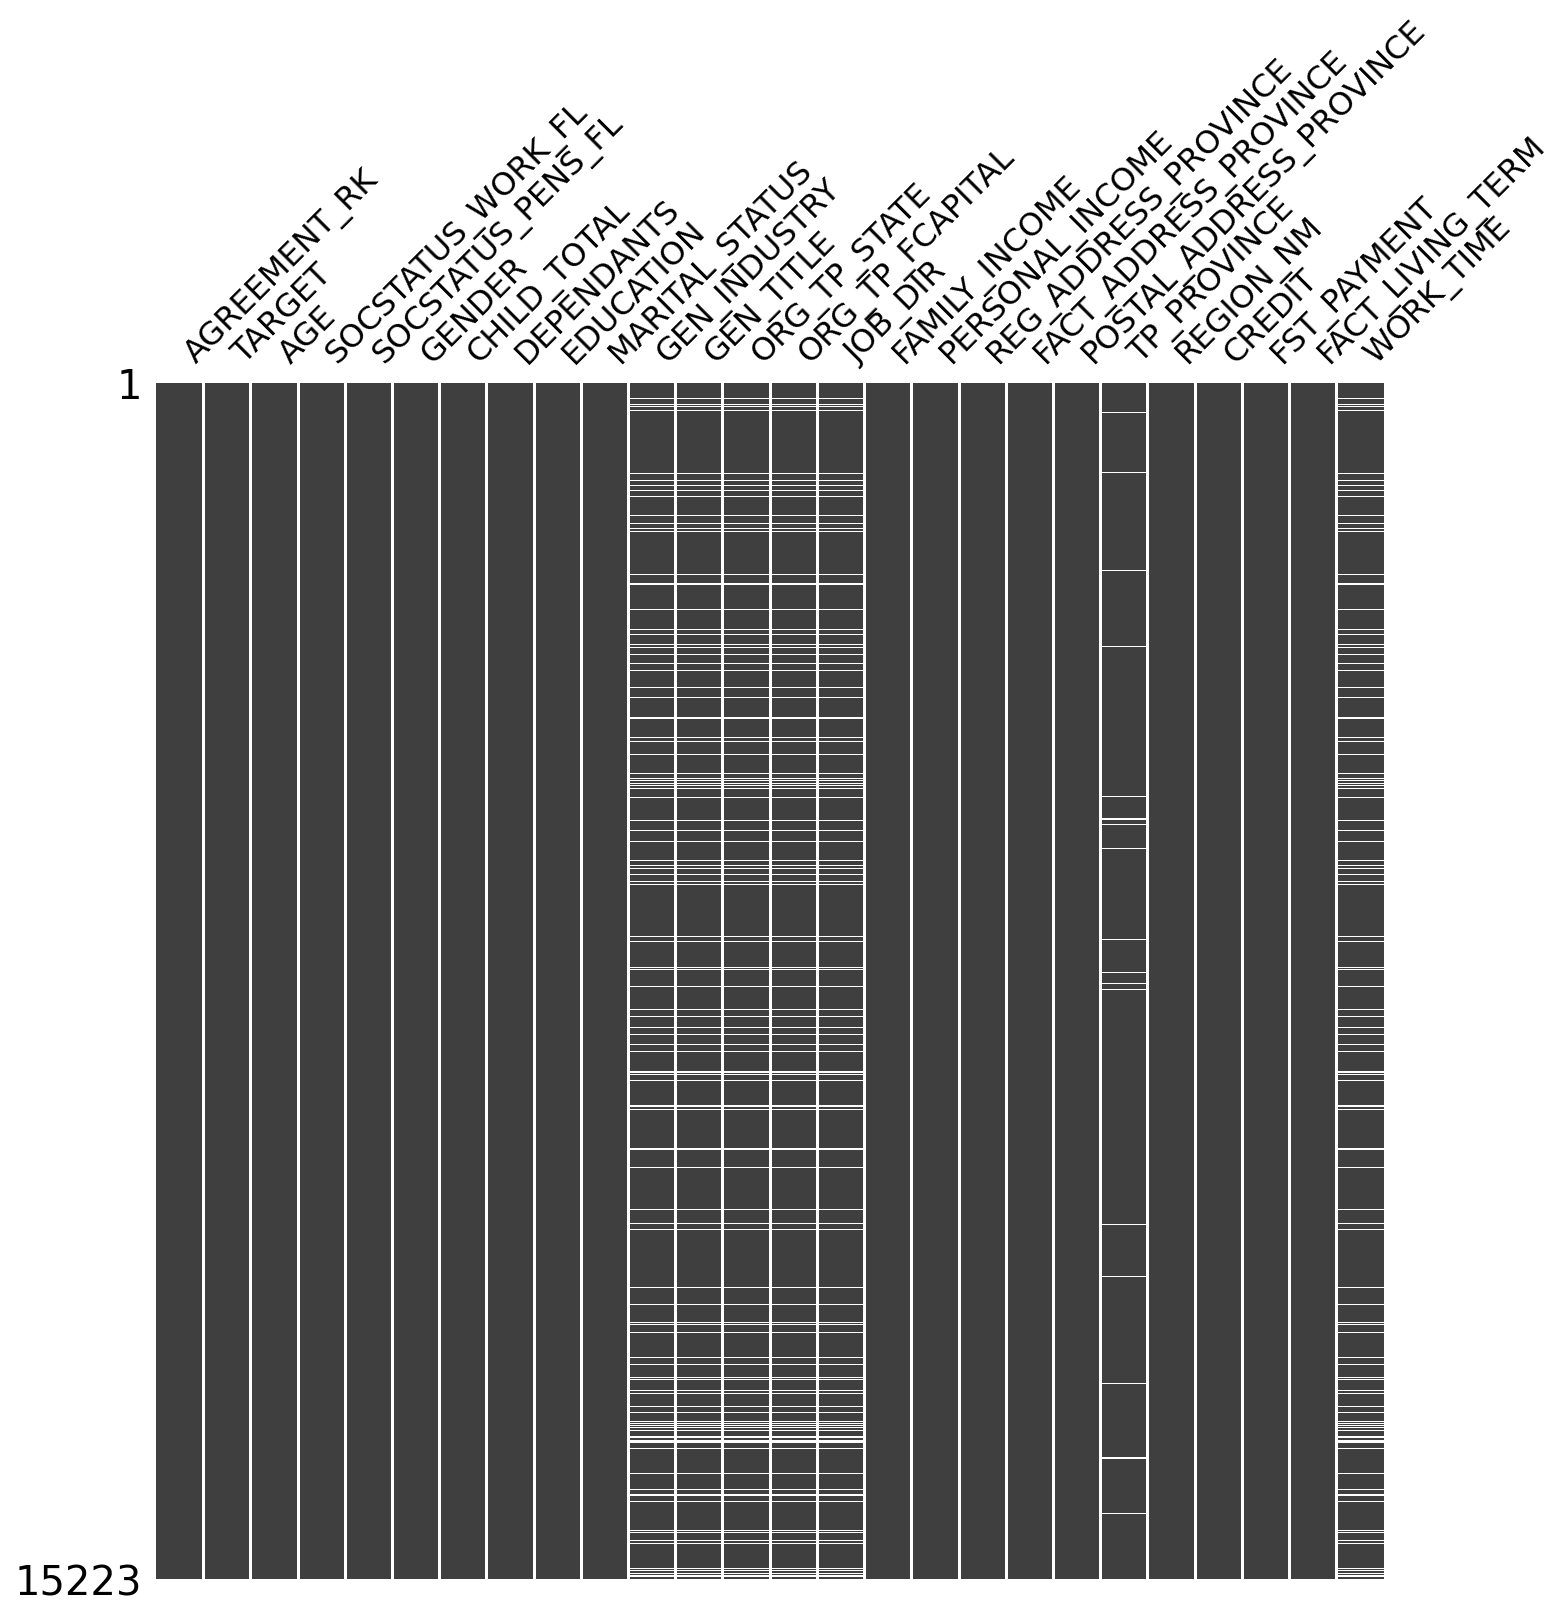

In [17]:
# визуализируем пропуски с помощью missingno
msno.matrix(data, sparkline=False, figsize=(11, 11));

In [18]:
# выводим информацию о пропусках
data.isnull().sum()

AGREEMENT_RK                  0
TARGET                        0
AGE                           0
SOCSTATUS_WORK_FL             0
SOCSTATUS_PENS_FL             0
GENDER                        0
CHILD_TOTAL                   0
DEPENDANTS                    0
EDUCATION                     0
MARITAL_STATUS                0
GEN_INDUSTRY               1367
GEN_TITLE                  1367
ORG_TP_STATE               1367
ORG_TP_FCAPITAL            1365
JOB_DIR                    1367
FAMILY_INCOME                 0
PERSONAL_INCOME               0
REG_ADDRESS_PROVINCE          0
FACT_ADDRESS_PROVINCE         0
POSTAL_ADDRESS_PROVINCE       0
TP_PROVINCE                 295
REGION_NM                     1
CREDIT                        0
FST_PAYMENT                   0
FACT_LIVING_TERM              0
WORK_TIME                  1368
dtype: int64

In [19]:
# случайно отберем наблюдения, в которых переменная
# SOCSTATUS_PENS_FL принимает значение 1
data[data['SOCSTATUS_PENS_FL'] == 1].sample(frac=0.003, random_state=42)

,AGREEMENT_RK,TARGET,AGE,SOCSTATUS_WORK_FL,SOCSTATUS_PENS_FL,GENDER,CHILD_TOTAL,DEPENDANTS,EDUCATION,MARITAL_STATUS,GEN_INDUSTRY,GEN_TITLE,ORG_TP_STATE,ORG_TP_FCAPITAL,JOB_DIR,FAMILY_INCOME,PERSONAL_INCOME,REG_ADDRESS_PROVINCE,FACT_ADDRESS_PROVINCE,POSTAL_ADDRESS_PROVINCE,TP_PROVINCE,REGION_NM,CREDIT,FST_PAYMENT,FACT_LIVING_TERM,WORK_TIME
11552,67148921,0,59,1,1,1,1,0,Среднее,Вдовец/Вдова,Металлургия/Промышленность/Машиностроение,Специалист,Частная компания,Без участия,Пр-техн. обесп. и телеком.,от 10000 до 20000 руб.,12000,Курганская область,Курганская область,Курганская область,Курганская область,УРАЛЬСКИЙ,12315.0,1369.0,249,408.0
5031,62256461,0,52,0,1,1,1,0,Среднее специальное,Состою в браке,NaN,NaN,NaN,NaN,NaN,от 10000 до 20000 руб.,12000,Воронежская область,Воронежская область,Воронежская область,Воронежская область,ЦЕНТРАЛЬНЫЙ 2,26138.0,0.0,29,NaN
816,60110378,0,34,1,1,0,0,0,Среднее специальное,Не состоял в браке,Банк/Финансы,Рабочий,Частная компания,Без участия,Вспомогательный техперсонал,от 10000 до 20000 руб.,12000,Волгоградская область,Волгоградская область,Волгоградская область,Волгоградская область,ЮЖНЫЙ,12000.0,2598.0,60,48.0
13531,74177319,0,62,0,1,1,0,0,Среднее специальное,Состою в браке,NaN,NaN,NaN,NaN,NaN,от 5000 до 10000 руб.,4000,Приморский край,Приморский край,Приморский край,Приморский край,ДАЛЬНЕВОСТОЧНЫЙ,5436.0,4434.0,168,NaN
13326,74017970,0,65,0,1,1,1,0,Среднее специальное,Состою в браке,NaN,NaN,NaN,NaN,NaN,от 10000 до 20000 руб.,6500,Оренбургская область,Оренбургская область,Оренбургская область,Оренбургская область,ПОВОЛЖСКИЙ,7410.0,830.0,408,NaN
9454,66195059,0,56,1,1,1,0,0,Среднее специальное,Состою в браке,Государственная служба,Специалист,Государственная комп./учреж.,Без участия,Участие в основ. деятельности,от 20000 до 50000 руб.,17000,Краснодарский край,Краснодарский край,Краснодарский край,Краснодарский край,ЮЖНЫЙ,23355.0,2595.0,396,360.0


In [20]:
# создаем список интересующих нас переменных
ptrn = 'GEN_|ORG_|WORK_TIME|JOB'
work_cols = data.columns[data.columns.str.contains(ptrn)].tolist()
# выводим количество наблюдений, в которых переменная SOCSTATUS_PENS_FL 
# принимает значение 1 И при этом переменная из рассматриваемого
# списка имеет пропуск
for col in work_cols:
    # записываем условие
    cond = (data[col].isnull()) & (data['SOCSTATUS_PENS_FL'] == 1)
    # записываем частоты
    freq = cond.value_counts()
    # печатаем имя переменной и частоты
    print(col)
    print(freq)
    print("")

GEN_INDUSTRY
False    13857
True      1366
dtype: int64

GEN_TITLE
False    13857
True      1366
dtype: int64

ORG_TP_STATE
False    13857
True      1366
dtype: int64

ORG_TP_FCAPITAL
False    13859
True      1364
dtype: int64

JOB_DIR
False    13857
True      1366
dtype: int64

WORK_TIME
False    13856
True      1367
dtype: int64



In [21]:
# удаляем из списка переменную WORK_TIME
work_cols.remove('WORK_TIME')
# заменяем пропуски в переменных GEN_ INDUSTRY, GEN_TITLE, 
# ORG_TP_STATE, ORG_TP_FCAPITAL, JOB_DIR  на "Не указано",
# если в интересующей нас переменной есть пропуск 
# И при этом переменная SOCSTATUS_PENS_FL имеет значение 1
for col in work_cols:
    data[col] = np.where(cond, 'Не указано', data[col])

In [22]:
# смотрим результаты
for col in work_cols:
    print(data[col].value_counts(dropna=False))
    print("")

Торговля                                     2385
Другие сферы                                 1709
Не указано                                   1367
Металлургия/Промышленность/Машиностроение    1356
Государственная служба                       1286
Здравоохранение                              1177
Образование                                   998
Транспорт                                     787
Сельское хозяйство                            702
Строительство                                 573
Коммунальное хоз-во/Дорожные службы           533
Ресторанный бизнес/Общественное питание       408
Наука                                         403
Нефтегазовая промышленность                   225
Сборочные производства                        172
Банк/Финансы                                  169
Энергетика                                    145
Развлечения/Искусство                         141
ЧОП/Детективная д-ть                          136
Информационные услуги                         108


In [23]:
# выполняем импутацию переменной WORK_TIME нулями
cond = (data['WORK_TIME'].isnull()) & (data['SOCSTATUS_PENS_FL'] == 1)
data['WORK_TIME'] = np.where(cond, 0, data['WORK_TIME'])

In [24]:
# посмотрим количество пропусков в WORK_TIME
data['WORK_TIME'].isnull().sum()

1

In [25]:
# проверяем, есть ли наблюдения, в которых разница между 
# возрастом и временем работы в годах меньше 16 (например, 
# у 30-летнего время работы в годах составляет 20 лет,
# получается, он работает с 10 лет)
data[(data['AGE'] - data['WORK_TIME'] / 12) < 16][['AGE', 'WORK_TIME']]

,AGE,WORK_TIME
148,43,360.0
676,53,780.0
1092,45,1312.0
2179,23,156.0
2373,31,187.0
2532,58,4320.0
2983,44,600.0
3039,40,480.0
3323,39,612.0
3797,39,300.0


In [26]:
# заменяем значения на пропуски по условию
cond = (data['AGE'] - data['WORK_TIME'] / 12) < 16
data['WORK_TIME'] = np.where(cond, np.NaN, data['WORK_TIME'])

In [27]:
# проверяем, есть ли наблюдения, в которых количество
# лет проживания по месту фактического пребывания 
# превышает возраст
data[data['FACT_LIVING_TERM'] / 12 > data['AGE']][['AGE', 'FACT_LIVING_TERM']]

,AGE,FACT_LIVING_TERM
988,51,6534
1420,60,890
1640,23,336
2071,41,2240
2373,31,431
3711,23,288
5369,51,980
5681,31,3168
5772,42,546
5888,45,720


In [28]:
# заменяем значения на пропуски по условию
cond = data['FACT_LIVING_TERM'] / 12 > data['AGE']
data['FACT_LIVING_TERM'] = np.where(cond, 
                                    np.NaN, 
                                    data['FACT_LIVING_TERM'])

In [29]:
# пропуски в переменной TP_PROVINCE заменим значением
# переменной FACT_ADDRESS_PROVINCE
data['TP_PROVINCE'] = np.where(data['TP_PROVINCE'].isnull(), 
                               data['FACT_ADDRESS_PROVINCE'], 
                               data['TP_PROVINCE'])

In [30]:
# создаем обучающий массив признаков, тестовый массив признаков,
# обучающий массив меток, тестовый массив меток
train, test, y_train, y_test = train_test_split(
    data.drop('TARGET', axis=1), 
    data['TARGET'], 
    test_size=.3, 
    stratify=data['TARGET'], 
    random_state=100)

In [31]:
# заменяем пропуски в переменных GEN_INDUSTRY, GEN_TITLE, 
# ORG_TP_STATE, ORG_TP_FCAPITAL, JOB_DIR модами
simp = SimpleImputer(strategy='most_frequent')
simp.fit(train[work_cols])
train[work_cols] = simp.transform(train[work_cols])
test[work_cols] = simp.transform(test[work_cols])

In [32]:
# заменяем пропуски в переменной WORK_TIME минимальными
# значениями, вычисленными по категориям GEN_INDUSTRY
imp = GroupImputer(['GEN_INDUSTRY'], 
                   agg_col='WORK_TIME', 
                   agg_func='min')
imp.fit(train)
train = imp.transform(train)
test = imp.transform(test)

In [33]:
# заменяем пропуски в переменной FACT_LIVING_TERM минимальными
# значениями, вычисленными по категориям FACT_ADDRESS_PROVINCE
imp = GroupImputer(['FACT_ADDRESS_PROVINCE'], 
                   agg_col='FACT_LIVING_TERM', 
                   agg_func='min')
imp.fit(train)
train = imp.transform(train)
test = imp.transform(test)